# Mood-RL Demonstrations

Based on [Eldar & Niv (2015)](https://www.nature.com/articles/ncomms7149): *Interaction between emotional state and learning underlies mood instability*. 

## Reinforcement Learning Model
In traditional reinforcement learning models, the expected value ($v$) of a stimulus is updated according to a reward prediction error ($\delta$), which reflects the difference between the actual reward obtained ($r$) and the expected value ($\delta = r - v$). This simple framework has proved successful in explaining a wide range of behavioral and neural data. 

To account for effects of mood on valuation, the model is modified to compute predictions errors with respect to *perceived reward* rather than actual reward: 

> $\delta = r_\text{perceived} - v$

where perceived reward ($r_\text{perceived}$) is different from actual reward in that it reflects the biasing effect of mood ($m$):

> $r_\text{perceived} = r \cdot f^m$

Here, $m \in (-1,1)$ where a good mood is indicated by $0 < m < 1$, and a bad mood is indicated by $-1 < m < 0$). $f$ is a positive constant that indicates the direction and extent of the mood bias. If $f=1$, moos does not bias the perception of reward. If $f>1$, mood exerts positive feedback as reward is perceived as larger in a good mood and smaller in a bad mood. Conversely, if $0 < f < 1$, mood exerts negative feedback as reward is perceived as smaller in a good mood and larger in a bad mood. 

To model the effects of unexpected outcomes on mood, mood is assumed to reflect recent prediction-error history ($h$), tracked using a step-size parameters $\eta_h$:

> $h = h + \eta_h (\delta - h)$

and is constrained to -1 and 1 by a sigmoid function:

> $m = \text{tanh} \ h$

Similar to traditional reinforcement learning models, expected values are updated after every trial according to the reward prediction error with a step-size (learning rate) parameter $\eta_v$:

> $v = v + \eta_v \delta$

## Demonstrations

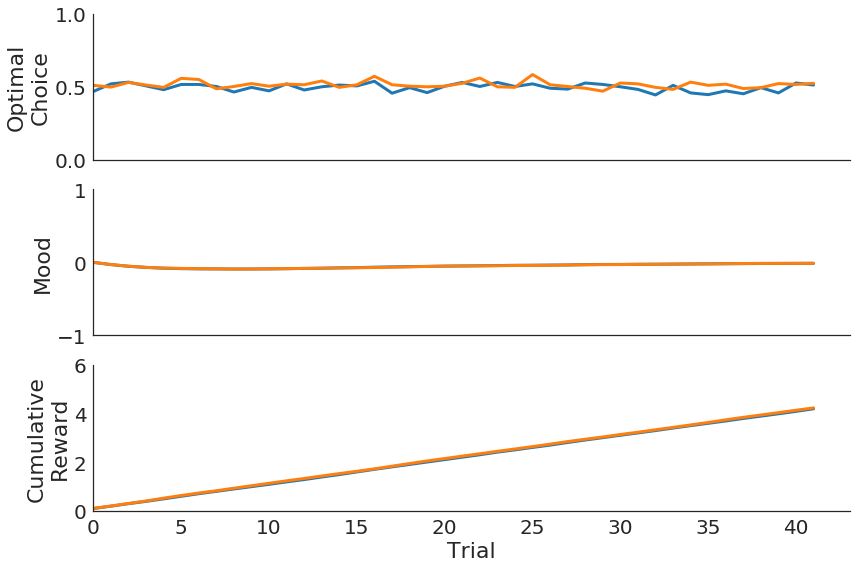

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from simulations import *
from utilities import *
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Agent parameters.
parameters = [(0, 0.2, 0.2, 1.0),
              (1, 0.2, 0.2, 1.0)]
Q = 0.25
M = 0

## Game parameters.
probabilities = (0.2, 0.4, 0.6)
reward = 0.25
n_trials = 42

## Simulation parameters.
n_simulations = 500

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
choices = np.zeros((n_simulations, len(parameters), n_trials))
rewards = np.zeros_like(choices)
moods = np.zeros_like(rewards)

## Main loop.
for i in range(n_simulations):
    
    ## Simulate slot machine game.
    X = slot_machine_game(n_trials=n_trials, probabilities=probabilities, reward=reward)

    for j, params in enumerate(parameters):

        ## Initialize agent.
        agent = MoodyAgent(*params)
    
        ## Play block of slot machine game.
        y, M, Q = agent.simulate(X, Q=Q, M=M)
        moods[i,j] = M

        ## Compute optimal choices.
        choices[i,j] = optimal_choice(X, y)
        
        ## Compute cumulative reward.
        rewards[i,j] = cumulative_reward(X, y)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, axes = plt.subplots(3,1,figsize=(12,8))
for j in range(len(parameters)):
    axes[0].plot(choices[:,j].mean(axis=0), lw=3)
    axes[0].set(xlim=(0), xticks=[], ylim=(0.0,1.0), ylabel='Optimal\nChoice')
    
    ## Plot mood.
    axes[1].plot(moods[:,j].mean(axis=0), lw=3)
    axes[1].set(xlim=(0), xticks=[], ylim=(-1,1), ylabel='Mood')
    
    ## Plot cumulative reward.
    axes[2].plot(rewards[:,j].mean(axis=0), lw=3)
    axes[2].set(xlim=(0), xlabel='Trial', ylim=(0,6), ylabel='Cumulative\nReward')
    
sns.despine()
plt.tight_layout()

## Figure 4

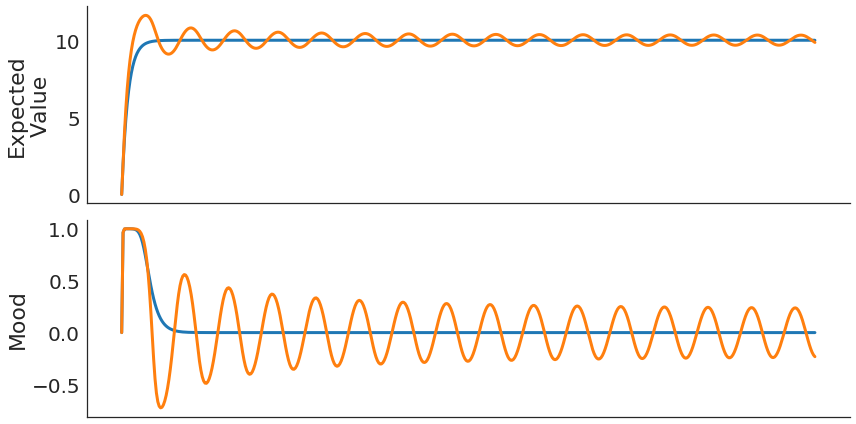

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from simulations import *
from utilities import *
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Agent parameters.
parameters = [(1, 0.2, 0.2, 1.0),
              (1, 0.2, 0.2, 1.2)]
Q = 0
M = 0

## Simulation parameters.
n_simulations = 250
n_trials = 500

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
evs = np.zeros((n_simulations, len(parameters), n_trials))
moods = np.zeros_like(evs)

## Generate design matrix.
X = np.ones((n_trials,1)) * 10

## Main loop.
for i in range(n_simulations):

    for j, params in enumerate(parameters):

        ## Initialize agent.
        agent = MoodyAgent(*params)
    
        ## Play block of slot machine game.
        y, M, Q = agent.simulate(X, Q=Q, M=M)
        
        evs[i,j] = Q.squeeze()
        moods[i,j] = M
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, axes = plt.subplots(2,1,figsize=(12,6))
for j in range(len(parameters)):
    
    axes[0].plot(evs[:,j].mean(axis=0), lw=3)
    axes[0].set(xticks=[], ylabel='Expected\nValue')
    
    ## Plot mood.
    axes[1].plot(moods[:,j].mean(axis=0), lw=3)
    axes[1].set(xticks=[], ylabel='Mood')
    
sns.despine()
plt.tight_layout()

## Open questions
1. Are simulated blocks representative of actual games? Are the simulated games currently returning a reward rate similar to the actual game?
2. In the current setup, the game seems odd. Choosing randomly (no learning), on average, yields similar reward rates as learning?
3. How is inverse temperature parameter in paper constrained between [0,1]? That seems to be a weird impediment to learning. Was there a multiplicative constant? What did the behavior look like?
4. How did mood get modeled from the SAMs? Normalized between -1 and 1? Mood does not seem very dynamic in the simulations above. 
5. How does cumulative reward relate to this? How much of the behavior can be driven by loss aversion?